# Lab 11 - Gaussian Processes

In this lab you'll use Gaussian process regression on synthetic data and get a sense for how to apply different kernels. Gaussian processes are a non-parametric model. They are typically configured to interpolate data in a smooth fashion, though they are very flexible and can be encouraged to prefer other kinds of interpolations (with periodic patterns, etc). Because they assume that the data varies smoothly, they tend to be poor at modeling sharp transitions.

Many of the exercises involve plotting, so once you realize that you're copying-and-pasting plotting code between cells, you may want to consider defining plotting functions early on and re-using those functions to make your code shorter and less cluttered/confusing, for your own sake!

**Run the code cell below** to import the required packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics           # For mean_squared_error
import sklearn.gaussian_process  # For GaussianProcessRegressor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore sklearn deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)       # Ignore sklearn deprecation warnings
np.set_printoptions(precision=3, suppress=True)  # Print array values as 0.0023 instead of 2.352e-3

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Gaussian Process Regression in 1D

Exercise 1.1&ndash;1.5 ask you to fit Gaussian processes to 1-dimensional synthetic data, learn how to plot the uncertainty in the predictions, and learn how to draw samples from a Gaussian process.

**Run the code cell below** to define some functions for plotting data and model. 

In [2]:
xlim = (-8, 8)
ylim = (-3, 10)

def f(x):
    """A function that we'll use to generate 1-d synthetic data. """
    return (4.0*np.exp(-np.abs(x+1.0)/3) + 6.0*np.exp(-np.abs(x-2.0)/1)).squeeze()

def plot_f():
    """Plots f(x) densely over the entire x-axis."""
    x = np.linspace(*xlim, 200)
    plt.plot(x, f(x), ':k', alpha=0.2)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')

<div style="border-bottom: 3px solid black"></div>

## 1.1 Generate synthetic data

You are asked to generate a synthetic training set $(\mathbf{X},\mathbf{y})$ where $\mathbf{X} \in \mathbb{R}^{N \times 1}$ and $\mathbf{y} \in \mathbb{R}^{N}$ where $y_i = f(x_i)$ using the $f$ function defined above. Your $x_i$ values should be sampled uniformly at random from $\mathcal{U}[-5, 5]$.

**Write a few lines of code** to generate the synthetic data and plot the resulting data points overlayed with the true underlying function. Use $N=5$. Your code should be vectorized (no loops), with a single call to the **[np.randum.uniform](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.uniform.html)** function. You may use the *plot_f* function to plot the actual function from which you sampled the data. Your plot should look as follows:
![image](img/gp_data_1.png)

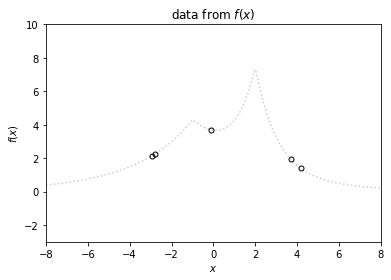

In [3]:
np.random.seed(5)

# Your code here.
N = 5
X = np.random.uniform(-5, 5, (N, 1))
y = f(X)

def plot_f_data(X, y, style='.k', label=None):
    plt.plot(X, y, style, markersize=10, markerfacecolor='none', label=label)

plot_f()
plot_f_data(X, y)
plt.title('data from $f(x)$');

<div style="border-bottom: 3px solid black"></div>

## 1.2 Fit a Gaussian process regressor to the data

Given an input example $\mathbf{x}$, a Gaussian process (GP) can provide a prediction $\hat{y}$ just like any other regressor. However, a GP can also provide a measure of its *uncertainty* in its prediction. Specifically, for every prediction $\hat{y}$ a GP can also provide a corresponding standard deviation estimate $\sigma$ that reflects its prediction uncertainty at point $\mathbf{x}$ in feature space. If $\mathbf{x}$ is close to a training point, then prediction $\hat{y}$ is typically confident (small corresponding $\sigma$). If $\mathbf{x}$ is far from any training point then prediction $\hat{y}$ reverts to some prior 'default' value (usually 0) with low confidence (large corresponding $\sigma$).

**Write a few lines of code** to fit a **[GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)** to your synthetic data $(\mathbf{X}, \mathbf{y})$ from Exercise 1.1. Use the default kernel.

In [4]:
# Your code here.
gp = sklearn.gaussian_process.GaussianProcessRegressor(normalize_y=True)
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

**Plot the predictions** of your Gaussian process after fitting. You should do this in two stages.

1. Plot the prediction curve of $\hat{y}(x)$ densely over the entire $x$-axis of the plot, ranging from -8 to +8. Your curve should look like this:

![image](img/gp_default_fit_1.png)

2. Add the standard deviation to your plot $\hat{y}(x) \pm \sigma(x)$. Consult the documentation for *predict* function in order to see how to get the standard deviation. Usie Matplotlib's **[fill_between](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.fill_between.html)** function to show the width of the standard deviation at each point along the curve. (You may need to reshape arrays to be 1-dimensional for the purposes of plotting). Your curve should look like this:

![image](img/gp_default_fit_2.png)

*Tip:* Use *edgecolor*, *facecolor*, and *alpha* arguments to customize the appearance of *fill_between*. You will re-use this plotting code so putting it into a function that plots a GP's predictions is a good idea, but optional.

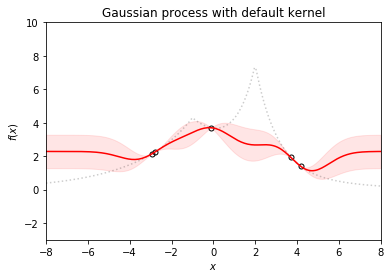

In [5]:
# Your code here.
def plot_f_predict(gp, alpha=0.1):
    X = np.linspace(*xlim, 200)
    y, std = gp.predict(X.reshape(-1, 1), return_std=True)
    y = y.ravel()
    plt.plot(X, y, '-r')
    plt.fill_between(X, y-std, y+std, edgecolor='r', facecolor='r', alpha=alpha)
    
plot_f()
plot_f_data(X, y)
plot_f_predict(gp)
plt.title("Gaussian process with default kernel");

You may notice a strange "sagging" in your curve. That is because a Gaussian process is configured, by default, to assume that all predictions should be $\hat{y}=0$ when far enough away from the data. Look at the documentation for the *normalize_y* parameter, then **use it and re-run your code cells**. You should see the new GP does not "sag downward" anymore, but it should instead "default" to the average of the $y_i$ values.

* If you re-run your code cells but comment out the line(s) that fit the data $(\mathbf{X}, \mathbf{y})$, what happens to the prediction plot?

<div style="border-bottom: 3px solid black"></div>

## 1.3 Handling noisy observations

Gaussian processes are non-parametric models. By default they assume that each target is perfectly measured, with no measurement noise. Under this assumption the right thing to do is to fit each data point perfectly, even if that means introducing extreme variability in the resulting interpolation.

However, Gaussian processes can be configured to be robust to noise. In scikit-learn the degree of "robustness" is controlled by the ***alpha* hyperparameter.** You will use the *alpha* parameter in this exercise.

**Write a few lines of code** to generate noisy versions of your targets, specifically $\mathbf{y}_\text{noisy} = \mathbf{y} + \mathbf{\epsilon}$ where $\mathbf{\epsilon} \sim \mathcal{N}(0,0.5)$. You should plot your data, resulting in the following plot:
![image](img/gp_data_noisy_1.png)

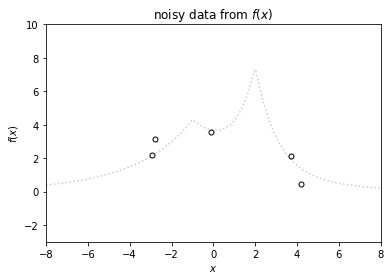

In [6]:
np.random.seed(3)

# Your code here.
y_noisy = y + 0.5*np.random.randn(N)

plot_f()
plot_f_data(X, y_noisy)
plt.title('noisy data from $f(x)$');

**Fit a Gaussian process** to the noisy targets and **plot the resulting predictions**. (Continue using *normalize_y=True*.) You should see, in particular, a steep upward slope caused by the two leftmost points.

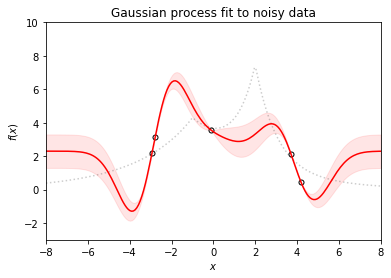

In [7]:
# Your code here.
gp = sklearn.gaussian_process.GaussianProcessRegressor(normalize_y=True)
gp.fit(X, y_noisy)

plot_f()
plot_f_data(X, y_noisy)
plot_f_predict(gp)
plt.title('Gaussian process fit to noisy data');

In the Scikit-learn Gaussian process implementation, the parameter *alpha* controls the degree to which the regressor "doubts" its targets (assumes they might be subject to Gaussian noise). When *alpha* is very small, then the regressor assumes that the targets are perfectly measured with no noise. When *alpha* is large, the regressor assumes the targets are only approximate, and that it need not pass directly through them.

**Fit another Gaussian process** but this time use the *alpha* parameter, changing it until prediction curve is not affected by the noise. Plot your result. You should see that the function no longer insists on passing directly through each data point.

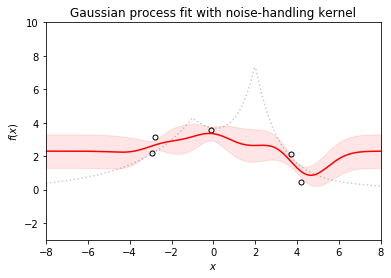

In [8]:
# Your code here.
gp = sklearn.gaussian_process.GaussianProcessRegressor(normalize_y=True, alpha=0.2)
gp.fit(X, y_noisy)

plot_f()
plot_f_data(X, y_noisy)
plot_f_predict(gp)
plt.title('Gaussian process fit with noise-handling kernel');

<div style="border-bottom: 3px solid black"></div>

## 1.4 Evaluate a GP on test data

Here you will generate some additional synthetic data for testing, and evaluate the accuracy of your GP predictions.

**Write a few lines of code** to generate a test set *X_test* and *y_test*. There should be ten (10) $x_i$ values in the test set, sampled uniformly from range $[-7,7]$ (use the *np.linspace* function). Plot your test data alongside the original (non-noisy) training points. Your plot should look like this:
![image](img/gp_data_test_1.png)

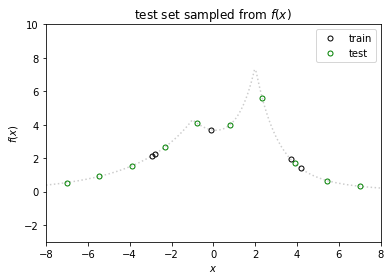

In [9]:
# Your code here.
X_test = np.linspace(-7, 7, 10).reshape(-1, 1)
y_test = f(X_test)

plot_f()
plot_f_data(X, y, label='train')
plot_f_data(X_test, y_test, '.g', label='test')
plt.plot()
plt.title('test set sampled from $f(x)$')
plt.legend();

**Write a few lines of code** to to fit a Gaussian process to the (non-noisy) training data. Use the default parameters. Plot your GP's predictions. Your plot should look as follows:
![image](img/gp_test_fit_1.png)

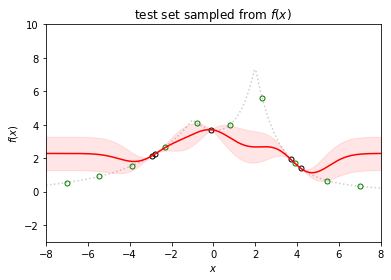

In [10]:
# Your code here.
gp = sklearn.gaussian_process.GaussianProcessRegressor(normalize_y=True)
gp.fit(X, y)
#gp.fit(X_test, y_test)  # Doing this drives R^2 to 1.0 and MSE to 0.0 on the test set.

plot_f()
plot_f_data(X, y, label='train')
plot_f_data(X_test, y_test, '.g', label='test')
plot_f_predict(gp)
plt.plot()
plt.title('test set sampled from $f(x)$');

A *GaussianProcessRegressor* object has a *score(X,y)* function just like other regressors. The default score is the *$R^2$ coefficient*, which is the square of the [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between the predictions and the targets. An $R^2$ of 1.0 means perfect correlation, and an $R^2$ of 0.0 means no correlation at all.

**Write a few lines of code** to print three outputs:
1. Print the list of residual errors between test predictions and test targets.
2. Print the mean squared error between test predictions and test targets.
3. Print the $R^2$ coefficient between test predictions and test targets.

Your output should be something like
```
Residuals: <array of 10 values; compare with your plot>
Mean squared error: <value>
R^2 coefficient: <value>
```

In [11]:
y_pred = gp.predict(X_test)
print("Residuals:", y_test - y_pred)
print("Mean squared error:", sklearn.metrics.mean_squared_error(y_test, y_pred))
print("R^2 coefficient:",    gp.score(X_test, y_test))

Residuals: [-1.74  -1.303 -0.262  0.033  0.549  0.749  2.936 -0.011 -0.825 -1.92 ]
Mean squared error: 1.8644474593794378
R^2 coefficient: 0.37023380632973635


Finally, try **re-training your GP** but this time **directly on the test set**. What happens to the mean squared error and to the $R^2$ coefficient?

<div style="border-bottom: 3px solid black"></div>

## 1.5 Sample from a GP and plot the resulting sample functions

A Gaussian process defines a probability distribution over *functions* $\hat{y}(\mathbf{x})$. When you fit a GP to data, the GP's distribution over functions changes:
* functions that are consistent with the data (interpolate the data) receive high probability, and 
* functions that are inconsistent (do not interpolate the data) receive extremely low probability.

So, mathematically speaking, when you draw a 'sample' from a GP, you are getting back a function $\hat{y}_j \sim \mathcal{GP}$ that can be evaluated as $\hat{y}_j(\mathbf{x})$ at any $\mathbf{x}$, not just at the training points $\mathbf{x}_i$. In fact, when you call *predict* in scikit-learn, the curve $\hat{y}(\mathbf{x})$ you get back is actually the expected value $\mathbb{E}[\hat{y}_j(\mathbf{x})]$ over all these possible functions. That is why you can also ask for the standard deviation $\sigma(\mathbf{x})$: it is the standard deviation over these functions when evaluated at $\mathbf{x}$.

Look at the documentation for the **[sample_y](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor.sample_y)** method. Try asking it for *n_samples=3*. Each sample function is evaluated at the same $\mathbf{x}_i$ points that you pass in, so ask the GP to evaluate the sample functions densly across the $x$-axis. You can do this with a single call to the *sample_y* function.

**Write a few lines of code** to train a Gaussian process on the **noisy data** in Exercise 1.3 (but without accounting for noise) and to plot the samples so that they overlap. Your final plot should look like this: 
![image](img/gp_default_noisy_samples_1.png)
*Tip:* Calling Matplotlib's *plot(x,y)* function with an *x* of shape *(N)* but a *y* of shape *(N,J)* will cause all *J* columns of *y* to be plotted as separate series.

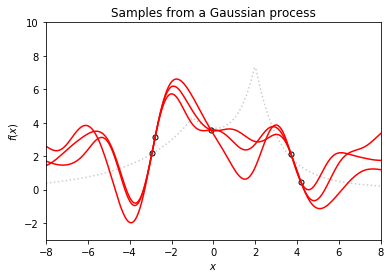

In [12]:
# Your code here.
gp = sklearn.gaussian_process.GaussianProcessRegressor(normalize_y=True)
gp.fit(X, y_noisy)

def plot_f_samples(gp, n_samples, alpha=1):
    X = np.linspace(*xlim, 200)
    y_samples = gp.sample_y(X.reshape(-1, 1), n_samples, random_state=2)
    plt.plot(X, y_samples, '-r', alpha=alpha)
    
plot_f()
plot_f_data(X, y_noisy)
plot_f_samples(gp, 3)
plt.title('Samples from a Gaussian process');

Now do the same but try plotting 100 samples from the Gaussian process rather than 3 samples. Your plot should look like this:

![image](img/gp_default_noisy_samples_2.png)

*Tip:* You can use a small *alpha* value (in the plotting function! not the GP!) to avoid 'overplotting' effects when drawing so many series on top of on another.

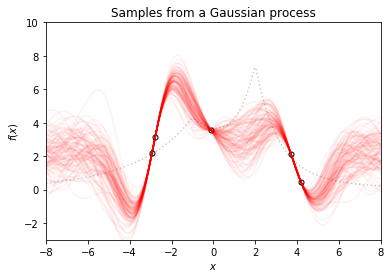

In [13]:
# Your code here.
plot_f()
plot_f_data(X, y_noisy)
plot_f_samples(gp, 100, alpha=0.05)
plt.title('Samples from a Gaussian process');

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 2. Kernels for Gaussian Processes

The notion of "smoothness" in a Gaussian process is determined by the specific choice of kernel. Here you will try specifying different kernels, and see how different kernels reflect different assumptions about how the data should be interpolated by the Gaussian process.

## 2.1 Learn how to specify a kernel

A GP needs some notion of 'distance' between to points $\mathbf{x}$ and $\mathbf{x}'$ in input space. That is how smoothness is determined: if two points $\mathbf{x}$ and $\mathbf{x}'$ are considered "close" by the GP (small distance) then the GP makes sure their output values are correlated.

This distance is specified by a *kernel* $k(\mathbf{x},\mathbf{x}')$, much the same as for an SVM. See the following [overview of scikt-learn's Gaussian process kernels](https://scikit-learn.org/stable/modules/gaussian_process.html#basic-kernels).

For example, the **[sklearn.gaussian_process.kernels.RBF](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html)** kernel (radial basis function kernel) takes its usual form:

$$
k_\ell(\mathbf{x}, \mathbf{x}') = \exp\left(-\frac{\left\|\mathbf{x}-\mathbf{x}'\right\|^2}{2\ell}\right)
$$

where $\ell$ is called the "length scale" of the kernel:
* large $\ell$ means $\hat{y}(\mathbf{x})$ and $\hat{y}(\mathbf{x}')$ are assumed to be correlated, even when $\left\|\mathbf{x}-\mathbf{x}'\right\|$ is large (*i.e.* $\hat{y}$ is very smooth);
* small $\ell$ means $\hat{y}(\mathbf{x})$ and $\hat{y}(\mathbf{x}')$ are assumed to be uncorrelated,  unless $\left\|\mathbf{x}-\mathbf{x}'\right\|$ is very small.

By default, the scikit-learn *GaussianProcessRegressor* uses an RBF kernel with length scale $\ell=1$. Here you will try to specify a kernel that simply reproduces this default.

**Write a few lines of code** to train a GP on the same synthetic training data from Exercise 1, but this time create *RBF* kernel object and pass it in as the *kernel* argument of the *GaussianProcessRegressor*. Your plot should look exacltly like it did in Exercise 1.2, as shown on the left below.

![image](img/rbf_optimized_length_scale.png)

**However,** the first time you try to do this, you may notice that your *GaussianProcessRegressor* tried adjust (optimize) the length scale hyperparameter $\ell$ of your RBF kernel, adjusting it to $\ell=1.53$ for some mysterious reason (above, right). The reasons for this will be explained in lecture, but for now we wish to disable this automatic "optimization" step &mdash; it makes it harder to understand kernels. **Use the *optimizer* parameter** of your Gaussian process to disable the kernel hyperparameter optimization.

After training, **confirm** that you disabled the kernel optimization by printing the *kernel_* attribute of your *GaussianProcessRegressor* object. That will show you what specific kernel the GP decided to use after fitting, and it should show *length_scale=1*.

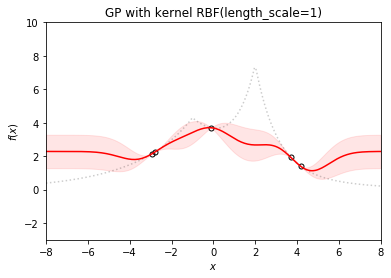

In [14]:
# Your code here.
kernel = sklearn.gaussian_process.kernels.RBF(1.0)
gp = sklearn.gaussian_process.GaussianProcessRegressor(kernel, optimizer=None, normalize_y=True)
gp.fit(X, y)

plot_f()
plot_f_data(X, y)
plot_f_predict(gp)
plt.title("GP with kernel %s" % gp.kernel_);

## 2.2 Experiment with different kernels

Kernels have hyperparameters, but the choice of kernel is itself a kind of hyperparameter, too. (That doesn't mean one has to try every kernel: if the data is not periodic, then there is probably no need to try a periodic kernel.)

Now that you know how to ask a *GaussianProcessRegressor* object to use a specific kernel, experiment with different kernels and see how they effect interpolation and extrapolation from your training data.

Specifically, train a separate GP for each of the following kernels and plot the predictions as before:
* RBF(0.2)
* RBF(1.0)
* RBF(5.0)
* RationalQuadratic(1.0, 0.02)
* RationalQuadratic(1.0, 0.02)
* RationalQuadratic(5.0, 1.00)
* ExpSineSquared(1.0, 1.0)
* ExpSineSquared(1.0, 5.0)
* ExpSineSquared(0.5, 5.0)
* RBF(5.0)*ExpSineSquared(1.0, 1.0)

Use the [overview of scikt-learn's Gaussian process kernels](https://scikit-learn.org/stable/modules/gaussian_process.html#basic-kernels) to learn how to do this. For example, one of your plots should look like this:
![image](img/kernels_exp_sine_1_5.png)

You should also display the $R^2$ score of each kernel when the GP is applied to the test set from Exercise 1.4. Which kernel had the highest score on this particular data set?

**Write code** to train the GPs and plot them. Use the for-loop structure below. Show the predictions of each GP in a separate figure (use *plt.figure()*).

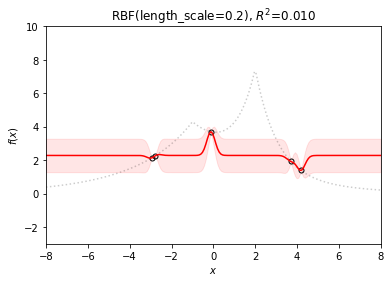

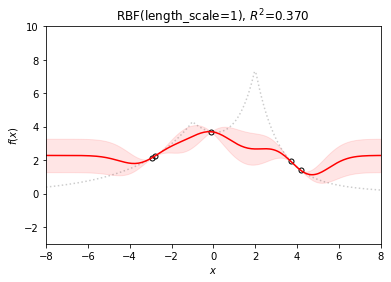

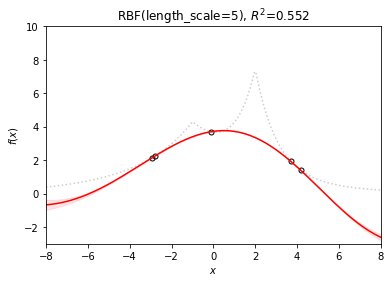

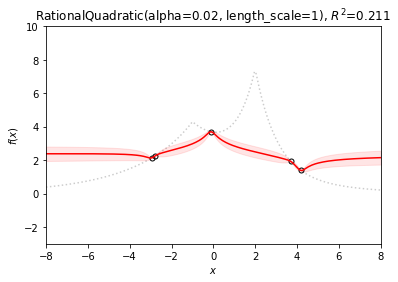

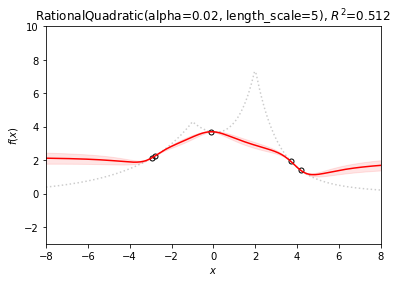

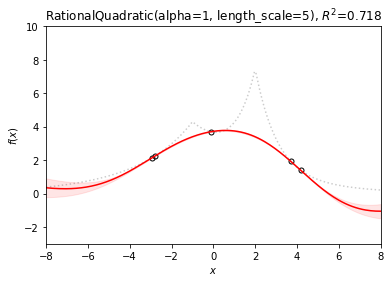

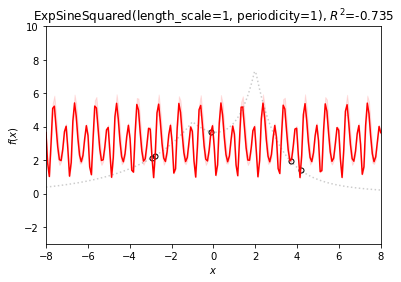

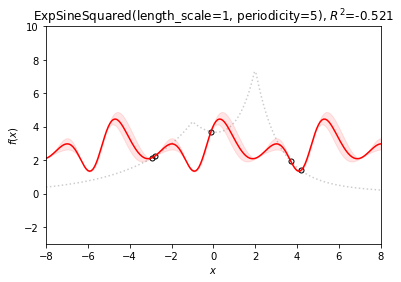

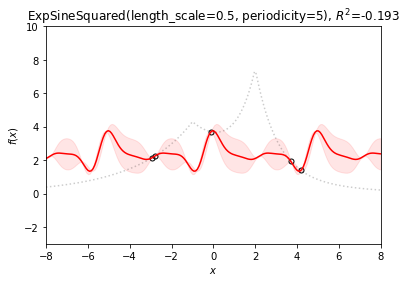

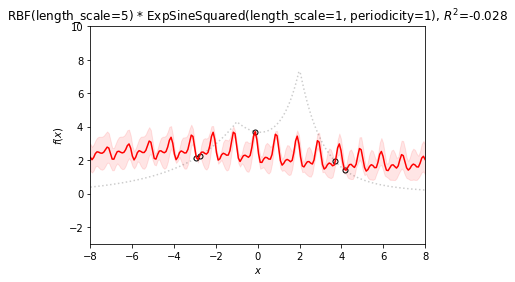

In [15]:
kernels = [
    # Your kernels here.
    sklearn.gaussian_process.kernels.RBF(0.2),
    sklearn.gaussian_process.kernels.RBF(1.0),
    sklearn.gaussian_process.kernels.RBF(5),
    sklearn.gaussian_process.kernels.RationalQuadratic(1.0, 0.02),
    sklearn.gaussian_process.kernels.RationalQuadratic(5.0, 0.02),
    sklearn.gaussian_process.kernels.RationalQuadratic(5.0, 1.0),
    sklearn.gaussian_process.kernels.ExpSineSquared(1.0, 1.0),
    sklearn.gaussian_process.kernels.ExpSineSquared(1.0, 5.0),
    sklearn.gaussian_process.kernels.ExpSineSquared(0.5, 5.0),
    sklearn.gaussian_process.kernels.RBF(5.0)*sklearn.gaussian_process.kernels.ExpSineSquared(1.0, 1.0),
]

for kernel in kernels:
    # Your training and plotting code here.
    gp = sklearn.gaussian_process.GaussianProcessRegressor(kernel, optimizer=None, normalize_y=True)
    gp.fit(X, y)

    plt.figure()
    plot_f()
    plot_f_data(X, y)
    plot_f_predict(gp)
    plt.title("%s, $R^2$=%.3f" % (gp.kernel_, gp.score(X_test, y_test)))

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 3. Multi-dimensional Gaussian processes

Gaussian processes extend naturally to any number of dimensions in $\mathbf{x}$.

**Run the code cell below** to define a function that will evaluate a multidimensional input as $g(\mathbf{x}) = \sum_{j=1}^D f(x_j)$ where $f$ is the original 1-dimensional function from Exercises 1 and 2. It also defines a function to plot the data in 2D.

In [16]:
def g(x):
    """N-dimensional version of f(x). If x has shape (N,D), result has shape (N,)."""
    return f(x).sum(axis=-1, keepdims=True)

def plot_g():
    """Plots the 2D heatmap of fd for 2-dimensional case"""
    x = np.linspace(*xlim, 200)
    x1, x2 = np.meshgrid(x, x)
    x = np.dstack([x1, x2])
    y = g(x).squeeze()
    plt.imshow(y, extent=xlim+xlim, origin='lower', vmin=0)
    plt.colorbar()
    plt.xlim(*xlim)
    plt.ylim(*xlim)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.gca().set_aspect('equal')

## 3.1 Generate 2D synthetic data

You are asked to generate a new training set $(\mathbf{X}, \mathbf{y})$ with each $\mathbf{x}_i = \begin{bmatrix} x_{i1} & x_{i2} \end{bmatrix}$ and sampled uniformly at random from $\mathcal{U}[-5, 5]$. You should generate $N=10$ training points.

**Write a few lines of code** to generate the training set and plot it in 2D, much like Exercise 1.1. Your plot should look like this:
![image](img/gp_data_2.png)

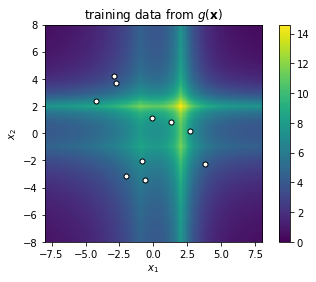

In [17]:
np.random.seed(5)

# Your code here.
N = 10
X = np.random.uniform(-5, 5, (N, 2))
y = g(X)

def plot_g_data(X, y):
    plt.plot(*X.T, '.k', markersize=10, markerfacecolor='w')

plot_g()
plot_g_data(X, y)
plt.title('training data from $g(\mathbf{x})$');

## 3.2 Fit a 2-dimensional Gaussian process with default kernel

Here you'll fit a Gaussian process to the 2D training data and then plot the prediction 'surface'.

**Write a few lines of code** to train a GaussianProcessRegressor on the 2D data. Don't forget to the *normalize_y* argument.

In [18]:
# Your code here.
gp = sklearn.gaussian_process.GaussianProcessRegressor(normalize_y=True)
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

**Plot the prediction surface** of your trained GP. Plot the prediction $\hat{y}(\mathbf{x})$ it as a heatmap, similar to how the function $g(\mathbf{x})$ was plotted by the function *plot_g*. In 2D it is harder to visualize the standard deviation $\sigma(\mathbf{x})$ at each point, so no need to try.

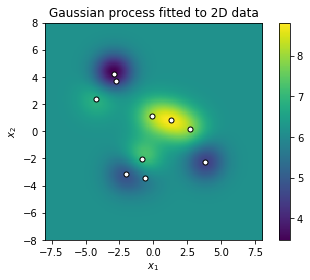

In [19]:
# Your code here.
def plot_g_predict(gp):
    x = np.linspace(*xlim, 200)
    x1, x2 = np.meshgrid(x, x)
    X = np.dstack([x1, x2]).reshape(-1, 2)
    y = gp.predict(X).reshape(x1.shape)
    plt.imshow(y, extent=xlim+xlim, origin='lower')
    plt.colorbar()
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

plot_g_data(X, y)
plot_g_predict(gp)
plt.title("Gaussian process fitted to 2D data");

Does the surface you see seem like a good approximation to the true function $g(\mathbf{x})$? What if you increase the number of training points to 100?

## 3.3 Fit 2-dimensional Gaussian processes with custom kernels, and learn how to handle intractible 

Repeat Exercise 2.2 but for the 2D training data. Your plots will now be 2D heatmaps. You should only plot the mean $\hat{y}(\mathbf{x})$, since it's too difficult to simultaneously visualize the standard deviation $\sigma(\mathbf{x})$ at each point on the surface. (In this exercise, you do **not** need to print the $R^2$ on any test set.)

For example, one of your plots should look like this:
![image](img/gp_fit_3.png)

If you receive an error message saying that one of your attempted kernels "is not returning a positive definite matrix", this means that it was impossible to fit your data points with the given kernel and assumed noise level. In other words, there is no way to explain the training data with the kernel you specified. When this happens, you can try increasing the *alpha* parameter in order to to give your Gaussian process more leeway when approximating the training data. However, this setting should be specific to each kernel. For example, the *ExpSineSquared* kernel may require a large *alpha*, whereas the *RBF* kernel does not.

**Write code** to fit each kernel to the 2D training data and then plot its prediction surface in a new figure. Don't forget to disable kernel hyperparameter optimization. In order to generate plots for kernels that need larger *alpha*, you should add an inner loop that catches an exception and then re-attempts training with increasing values of *alpha*$\in [0.001, 0.01, 0.1, 1, 10]$ until one of them succeeds.

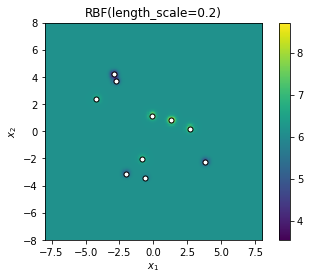

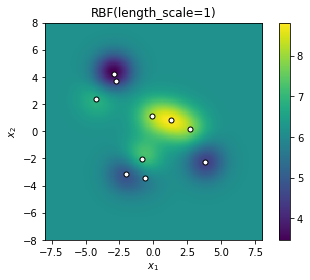

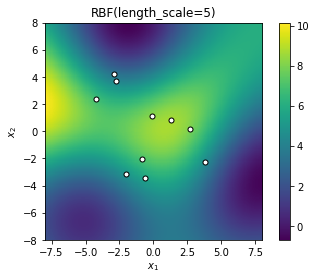

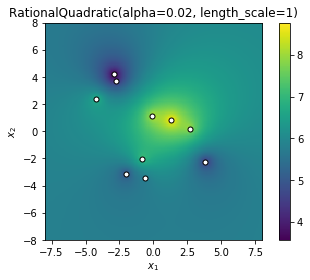

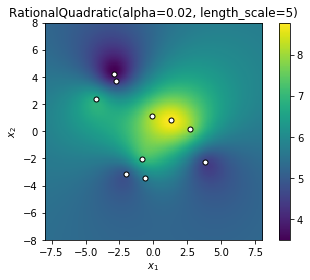

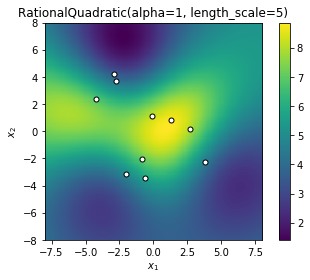

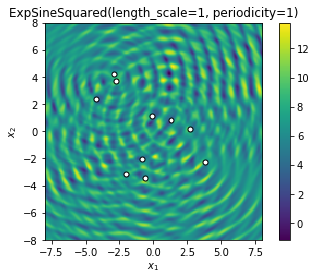

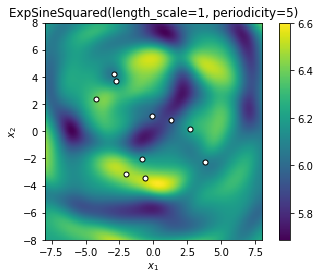

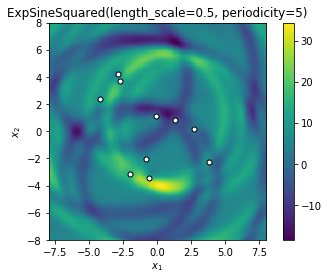

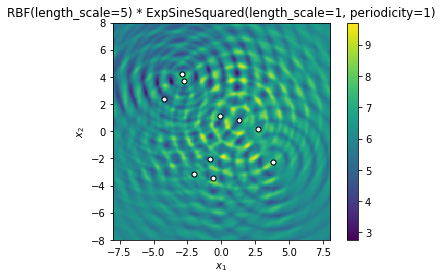

In [21]:
for kernel in kernels:  # Use same "kernels" list as Exercise 2.2
    # Your training and plotting code here.
    for alpha in [0.001, 0.01, 0.1, 1.0, 10.0]:
        try:
            gp = sklearn.gaussian_process.GaussianProcessRegressor(kernel, optimizer=None,
                                                                   alpha=alpha, normalize_y=True)
            gp.fit(X, y)
            break         # Success! Break from the for loop.
        except:
            continue      # Error: try again with larger alpha.

    plt.figure()
    plot_g_data(X, y)
    plot_g_predict(gp)
    plt.title("%s" % gp.kernel_)